# Creating Manipulation Station in a Robot Library

In [1]:
import time
from typing import List, Dict, Tuple
import numpy as np
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    BsplineTrajectory,
    DiagramBuilder,
    KinematicTrajectoryOptimization,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    DiagramBuilder,
    MinimumDistanceLowerBoundConstraint,
    Parser,
    PositionConstraint,
    Rgba,
    RigidTransform,
    Role,
    Solve,
    Sphere,
    StartMeshcat,
    Simulator
)

from pydrake.geometry import Meshcat
from manipulation import running_as_notebook
from manipulation.meshcat_utils import PublishPositionTrajectory
from manipulation.scenarios import AddIiwa, AddPlanarIiwa, AddShape, AddWsg, MakeManipulationStation
from manipulation.station import MakeHardwareStation, load_scenario
from manipulation.utils import ConfigureParser

In [2]:
from pydrake.all import Meshcat
meshcat = Meshcat(7006)

INFO:drake:Meshcat listening for connections at http://localhost:7006


## 1. Adding environment

In [3]:
model_directives = "directives:"
model_directives += """
- add_model:
    name: ground_floor
    file: file:///workspaces/RobotLibrarian/libenv/objects/ground_floor.sdf
- add_weld:
    parent: world
    child: ground_floor::ground_floor
    X_PC:
        translation: [0.0,0.0,0.0]
"""


### 1.1. Adding shelves

In [4]:
ROW_DIST_SHELF = 1.7
COLUMN_DIST_SHELF = 1.7
SHELF_OFFSET_X = 1.7
SHELF_OFFSET_Y = 2.4
SHELF_OFFSET_Z = 0.42
N_ROWS = 3
N_COLUMNS = 2
shelf_names = "ABCDEFGHIJKLMNOPQRST"
shelf_name_idx = -1
for n_row in range(N_ROWS):
    for n_col in range(N_COLUMNS):
        shelf_name_idx += 1
        shelf_name = shelf_names[shelf_name_idx]
        translation = np.array([SHELF_OFFSET_X,SHELF_OFFSET_Y,SHELF_OFFSET_Z]) \
                        + np.array([n_row * ROW_DIST_SHELF, n_col * COLUMN_DIST_SHELF, 0.0])
        model_directives += """
- add_model:
    name: shelf_"""+str(shelf_name)+"""
    file: file:///workspaces/RobotLibrarian/libenv/objects/library_shelf.sdf
- add_weld:
    parent: world
    child: shelf_"""+str(shelf_name)+"""::shelves_body
    X_PC:
        translation: ["""+str(translation[0])+""", """+str(translation[1])+""", """+str(translation[2])+"""]
        """


### 1.2. Adding table

In [5]:
table_translation = [1.0,0.25,0.53]
model_directives += """
- add_model:
    name: table
    file: file:///workspaces/RobotLibrarian/libenv/objects/library_table.sdf
- add_weld:
    parent: world
    child: table
    X_PC:
        translation: ["""+str(table_translation[0])+""", """+str(table_translation[1])+""", """+str(table_translation[2])+"""]
"""


### 1.3. Adding books

In [6]:
n_books = 10
book_dist = 0.13
book_offset = table_translation + np.array([-0.54,0.0,0.11])
book_names = shelf_names
for idx in range(n_books):
    book_translation = book_offset + np.array([idx*book_dist,0.0,0.0])
    model_directives += """
- add_model:
    name: book_"""+str(book_names[idx])+"""
    file: file:///workspaces/RobotLibrarian/libenv/objects/book.sdf
    default_free_body_pose:
        book:
            translation: ["""+str(book_translation[0])+""", """+str(book_translation[1])+""", """+str(book_translation[2])+"""]
            rotation: !Rpy { deg: [0, 0, -90]}
    """


## 2. Adding cameras

### 2.1. Adding table cameras

In [7]:
# model_directives +="""
#         - add_model:
#             name: table_visual_camera_1
#             file: package://manipulation/camera_box.sdf
# """

In [8]:
model_directives +="""
- add_frame:
    name: camera_table_above
    X_PF:
        base_frame: table
        rotation: !Rpy { deg: [-90.0, 0.0, .0]}
        translation: [0., 0., 0.5]

- add_model:
    name: camera0
    file: package://manipulation/camera_box.sdf

- add_weld:
    parent: camera_table_above
    child: camera0::base

- add_frame:
    name: camera_table_left
    X_PF:
        base_frame: table
        rotation: !Rpy { deg: [0.0, 0.0, 90.0]}
        translation: [0.9, 0., 0.1]

- add_model:
    name: camera1
    file: package://manipulation/camera_box.sdf

- add_weld:
    parent: camera_table_left
    child: camera1::base

- add_frame:
    name: camera_table_right
    X_PF:
        base_frame: table
        rotation: !Rpy { deg: [0.0, 0.0, -90.0]}
        translation: [-0.9, 0., 0.1]

- add_model:
    name: camera2
    file: package://manipulation/camera_box.sdf

- add_weld:
    parent: camera_table_right
    child: camera2::base

- add_frame:
    name: camera_behind_table
    X_PF:
        base_frame: table
        rotation: !Rpy { deg: [0.0, 0.0, 0.0]}
        translation: [0.0, -0.45, 0.1]

- add_model:
    name: camera4
    file: package://manipulation/camera_box.sdf

- add_weld:
    parent: camera_behind_table
    child: camera4::base
"""

In [9]:
#model_directives = "" #directives:"
scenario_data = """
cameras:
    table_camera_1:
        name: table_camera_1
        depth: True
        X_PB:
            base_frame: table
            translation: [0, 0, 0.8]
            rotation: !Rpy { deg: [180, 0, 90]}
    table_camera_2:
        name: table_camera_2
        depth: True
        X_PB:
            base_frame: table
            translation: [0, 0, 5.8]
            rotation: !Rpy { deg: [180, 0, 90]}
    table_camera_3:
        name: table_camera_3
        depth: True
        X_PB:
            base_frame: table
            translation: [0, 0, 5.8]
            rotation: !Rpy { deg: [180, 0, 90]}

    table_camera_4:
        name: table_camera_4
        depth: True
        X_PB:
            base_frame: table
            translation: [0, 0, 5.8]
            rotation: !Rpy { deg: [180, 0, 90]}
""" + model_directives

In [10]:
def setup_builder(mcat: Meshcat, time_step: float = 0.001):

    meshcat.Delete()
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    time_step = 0.01
    
    scenario = load_scenario(data=scenario_data)
    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat))

    parser = Parser(plant)
    ConfigureParser(parser)
    
    return builder, plant, scene_graph, station, parser
    
builder, plant, scene_graph, station, parser = setup_builder(meshcat)


plant.Finalize()
visualizer = MeshcatVisualizer.AddToBuilder(builder, station.GetOutputPort("query_object"), meshcat)
diagram = builder.Build()
diagram.set_name("plant and scene_graph")
context = diagram.CreateDefaultContext()
diagram.ForcedPublish(context)
simulator = Simulator(diagram)
plant_context = plant.GetMyContextFromRoot(simulator.get_mutable_context())
simulator.AdvanceTo(1.5)




==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html



udp_read_packet -- select:: Interrupted system call


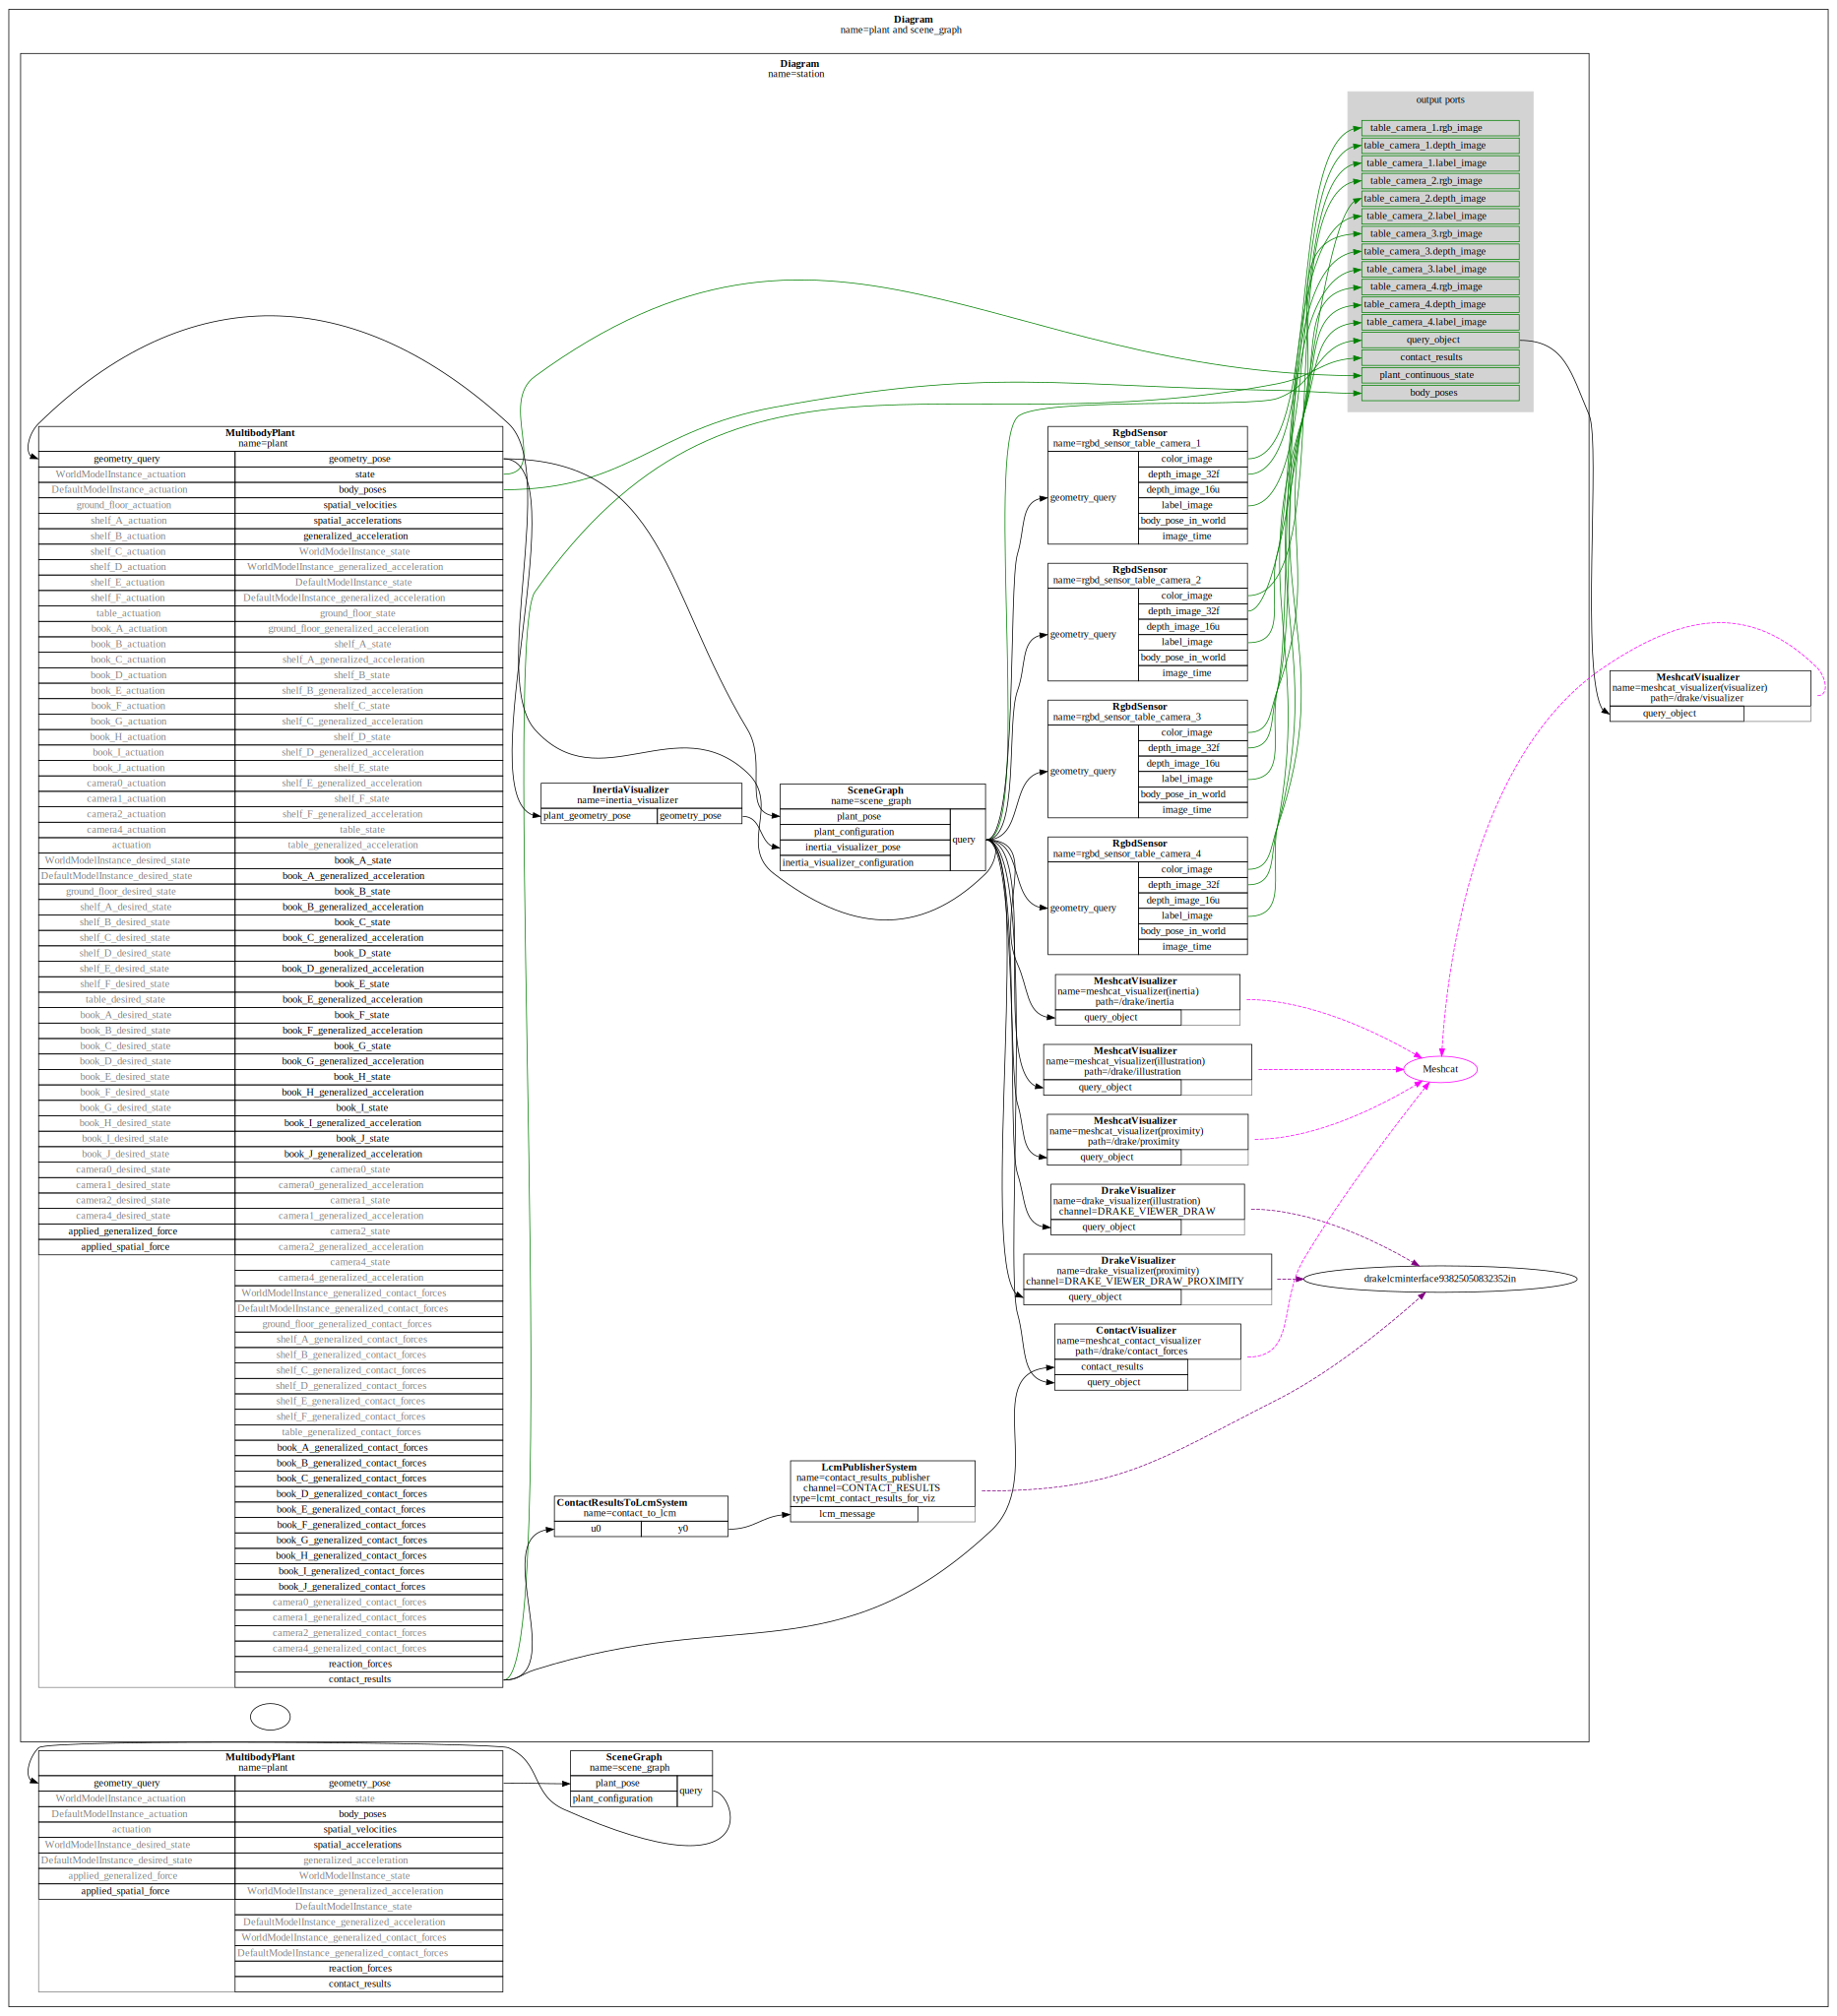

In [11]:
from utils import visualize_diagram
visualize_diagram(diagram)